In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
# $example off$
from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .appName("BucketedRandomProjectionLSHExample") \
        .getOrCreate()

In [3]:
def plti(im, h=8, label='BRAND', **kwargs):
    """
    Helper function to plot an image.
    """
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.subplot(title=label)
    plt.imshow(im, interpolation="none", **kwargs)
    plt.axis('off')

In [4]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
    
def run_lsh(input_col=None, candidates=None, key=None, top=5):
    
    
    lsh = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes",
                                  seed=12345, bucketLength=499.0)
    model = lsh.fit(candidates)
    
    nn = model.approxNearestNeighbors(candidates, key, numNearestNeighbors=top)
    #print(type(nn))
    displyTopK(nn, top)
    return nn

In [5]:
from pyspark.sql import functions as F 

def displyTopK(model, top):
    print("Approximately searching dfA for %s nearest neighbors of the key!" % str(top))
    model.show()

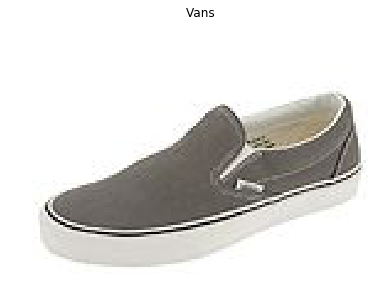

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
from showit import image, tile
from pyspark.ml.linalg import Vectors

shoe_image = "/home/faronr/ipython-notebooks/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/Vans/7226411.340024.jpg"
im = plt.imread(shoe_image)
plti(im, label=shoe_image.split('/')[-2])
b = im.ravel() # reshape to 1-dimensional vector space
# print(len(b))
key = Vectors.dense(im.ravel().tolist())

In [6]:
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
from showit import image, tile
from pyspark.ml.linalg import Vectors

# print(hash(s) % 10**8)
img_array = []
root = "/home/faronr/ipython-notebooks/ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/"
count=0
# Filter out Brands I don't want to look at
skip_list = ['Van','PUMA','Allrounder','DVS', 'Levi','Vivo','Meph', 'Finn', 'Bottega'\
             'Nike','Gola','ECCO','Cushe','Kid','Lacoste', 'Converse','Dansko']
for path, subdirs, files in os.walk(root):
    skip=False
    for i in skip_list:
        if i in path: 
            skip=True
            break
    
    if skip: continue
            
    if count > 2000: break
    for name in files:
        im = plt.imread(os.path.join(path, name))
        entry = tuple([hash(name) % 10**8, name, os.path.join(path, name), \
                       Vectors.dense(im.ravel().tolist())]) # reshape to 1-dimensional vector space (dense)
        img_array.append(entry)
        count = count+1

print('Shoe count: ' + str(count))
dfA = spark.createDataFrame(img_array, ["id", "name", "file_loc", "features"])
#dfA.show()
#dfA.printSchema()

Shoe count: 2084


In [7]:
result = run_lsh(input_col='features', candidates=dfA, key=key, top=10)

Approximately searching dfA for 10 nearest neighbors of the key!
+--------+------------------+--------------------+--------------------+--------+------------------+
|      id|              name|            file_loc|            features|  hashes|           distCol|
+--------+------------------+--------------------+--------------------+--------+------------------+
|98995866|   7909924.401.jpg|/home/faronr/ipyt...|[255.0,255.0,255....|[[-1.0]]| 8297.539575078868|
|91637648|   7567505.401.jpg|/home/faronr/ipyt...|[255.0,255.0,255....|[[-1.0]]| 9106.366948459743|
|52750572|  8100209.1761.jpg|/home/faronr/ipyt...|[255.0,255.0,255....|[[-1.0]]| 9210.323935671318|
|69739001|  7909624.4202.jpg|/home/faronr/ipyt...|[255.0,255.0,255....|[[-1.0]]| 9271.701515903109|
| 5062136|  7909925.1904.jpg|/home/faronr/ipyt...|[255.0,255.0,255....|[[-1.0]]| 9364.626474131255|
|62378856|  7813660.6700.jpg|/home/faronr/ipyt...|[255.0,255.0,255....|[[-1.0]]| 9783.211538140224|
|80458820| 7953234.68564.jpg|/home/

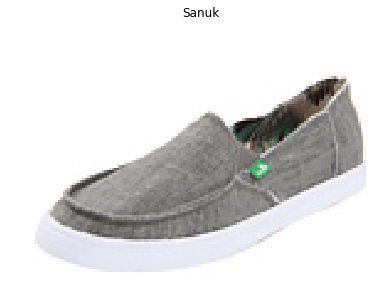

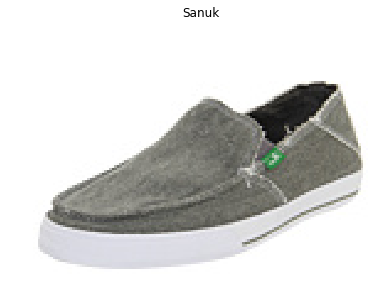

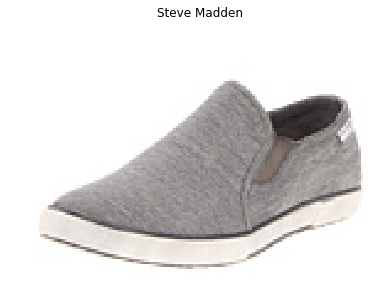

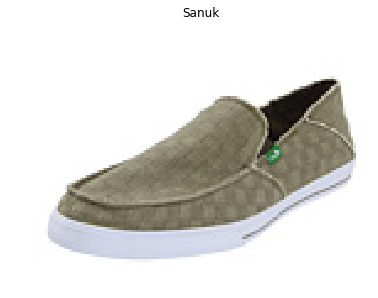

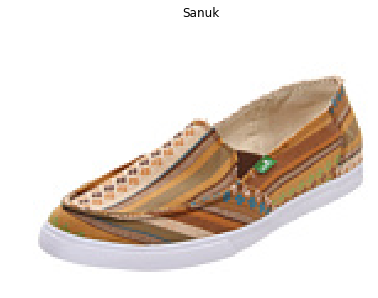

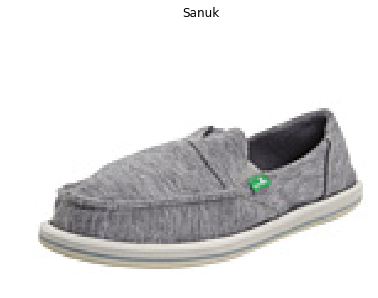

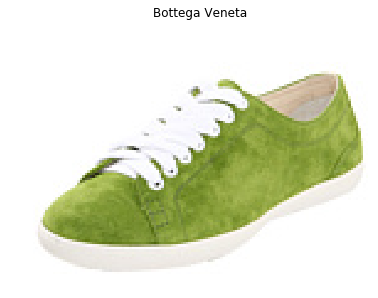

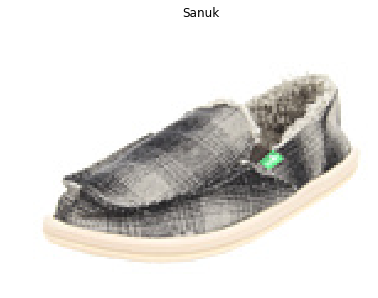

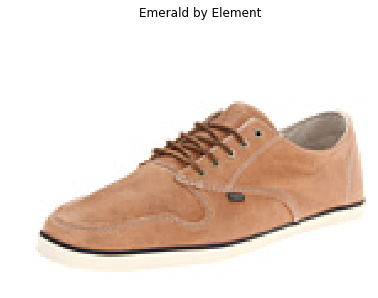

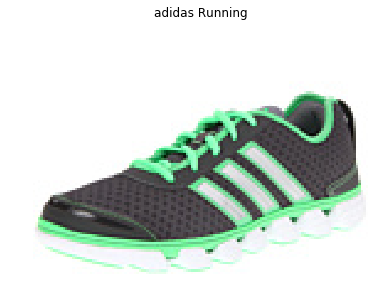

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
from showit import image, tile
from pyspark.ml.linalg import Vectors

data = result.toPandas()
for _, row in data.iterrows():
    shoe_image = row['file_loc']
    im = plt.imread(shoe_image)
    plti(im, label=shoe_image.split('/')[-2])